In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from livelossplot import PlotLosses
from tqdm import tqdm
from torch.utils.data import random_split

In [27]:
torch.manual_seed(42)
batch_size = 8
NUM_EPOCHS = 2
device = get_device()

Using device: cpu



In [28]:
def getAccuracy(model, loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [29]:
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    print()

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
        print("Data:")
        print('Devices available:',torch.cuda.device_count()) 
        print('Current Devices available:', torch.cuda.current_device() )
    return device

In [30]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])]
        )
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])],
        )

In [31]:
dataset = MNIST(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = MNIST(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ["0", "1", "2", "3", "4",
               "5", "6", "7", "8", "9"]

In [32]:
val_size = 10000
train_size = len(dataset) - val_size

In [33]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [34]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size * 2,
                                         shuffle=True, num_workers=2)

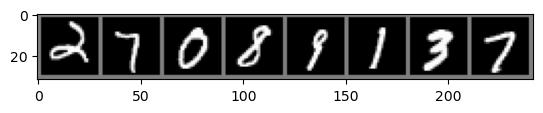

2     7     0     8     9     1     3     7    


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [39]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device) 

In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

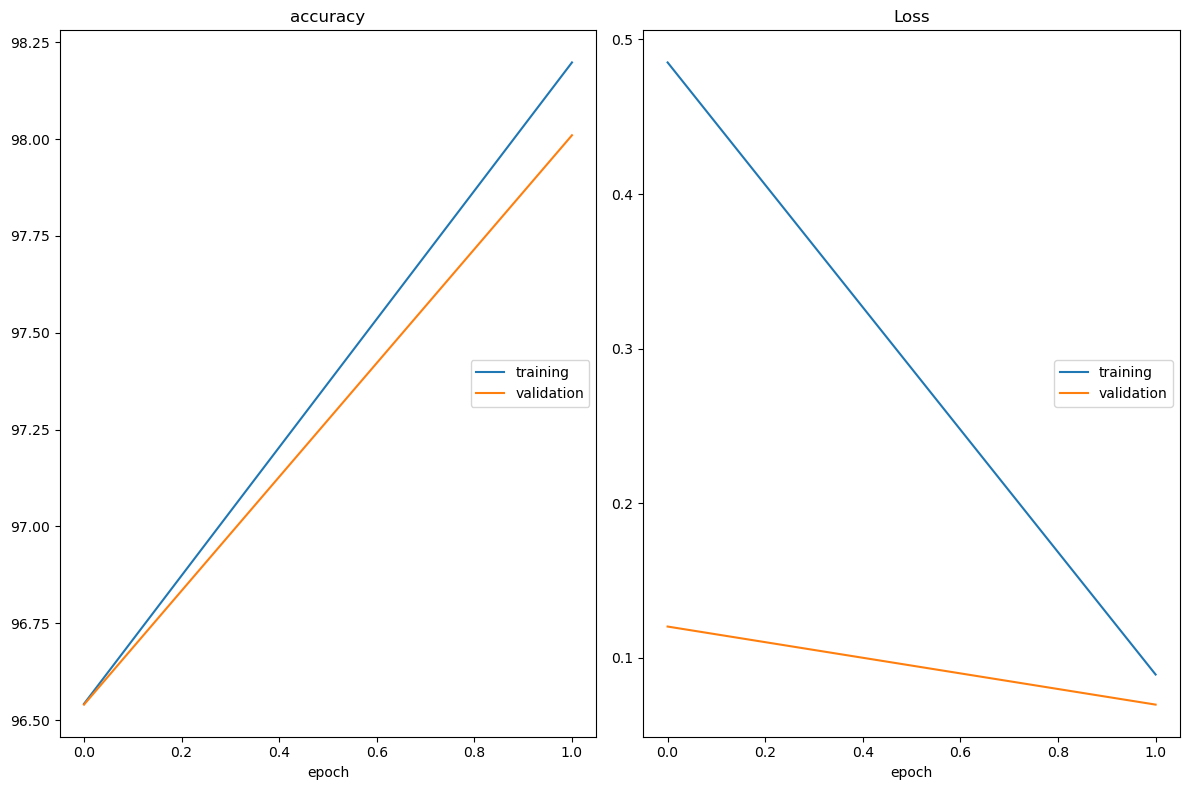

Training model...: 100%|██████████| 2/2 [03:20<00:00, 100.48s/it]

accuracy
	training         	 (min:   96.542, max:   98.198, cur:   98.198)
	validation       	 (min:   96.540, max:   98.010, cur:   98.010)
Loss
	training         	 (min:    0.089, max:    0.485, cur:    0.089)
	validation       	 (min:    0.070, max:    0.120, cur:    0.070)
Finished Training


In [41]:
liveplot= PlotLosses()
loss_lst = []
val_loss_lst = []
for epoch in tqdm(range(NUM_EPOCHS), desc = "Training model..."):  # loop over the dataset multiple times
    logs = {}
    epoch_total = 0.
    running_loss = 0.0
    validation_total = 0.
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_total += loss.item()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    with torch.set_grad_enabled(False):
        for i, (images, labels) in enumerate(validation_loader):
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)
            # forward 
            output = net(images)
            loss   = criterion(output, labels)

            validation_total += loss.item()
    logs["accuracy"] = getAccuracy(net, train_loader)
    logs["val_accuracy"] = getAccuracy(net, validation_loader)

    logs["loss"] = epoch_total / len(train_loader)
    logs["val_loss"] = validation_total /  len(validation_loader)
    val_loss = validation_total /  len(validation_loader)
    loss_lst.append(loss)
    val_loss_lst.append(val_loss)

    liveplot.update(logs)
    liveplot.send()


print('Finished Training')

In [ ]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')